# Primeiro Exercício

### Aluno: Matheus Jun Ota
### RA: 138889

> Fazer um programa de simulação e coletar dados para plotar um gráfico retardo médio x utilização. 
A utilização é a razão entre a taxa de chegada e a taxa de serviço do servidor. Assuma que o intervalo entre a chegada 
de pacotes é exponencialmente distribuído, bem como o tamanho dos pacotes. Entregar relatório com gráfico, código 
fonte e explicação de como derivou intervalo de confiança e qual foi o critério adotado para eliminar o transiente da 
simulação.

Queremos fazer a simulação de uma fila M/M/1 onde o a taxa de chegada e a taxa de serviço (proporcional ao tamanho do pacote) seguem a distribuição exponencial. Para isso utilizaremos a linguagem Python, e o relatório será escrito no Jupyter Notebook.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import math
import random
import statistics 
from collections import deque

class Queue():
    def __init__(self, arrivalRate, departureRate):
        self.usersInQueue = 0
        self.servicedUsers = 0
        self.currTime = 0
        self.arrivalParam = arrivalRate
        self.departureParam = departureRate
        self.arrivalTime = self.getRandomTime(self.arrivalParam)
        self.inQueueArrivals = deque()
        self.departureTime = float("inf")
        self.totalDelay = 0

A fim de facilitar a simulação, iremos proceder com uma abordagem baseada em orientação a objetos. Assim, começamos por declarar uma classe **Queue** que possui um construtor que recebe como parâmetros a taxa de chegada e a taxa de serviço. Além disso, vamos supor que os tempos utilizados no simulados estão em segundos. Os atributos da classe são os seguintes:

**usersInQueue**: número de usuários na fila 

**currTime**: tempo corrente na simulação da fila

**arrivalParam**: parâmetro utilizado na distribuição exponencial para obter o intervalo entre chegada de pacotes

**departureParam**: parâmetro utilizado na distribuição exponencial para obter o tempo de serviço do pacote

**arrivalTime**: tempo para a chegada do próximo pacote

**inQueueArrivals**: lista com os tempos de chegada dos pacotes que estão na fila

**departureTime**: tempo para a saída do próximo pacote

**totalDelay**: tempo total que os pacotes esperaram para serem atendidos.

In [2]:
class Queue(Queue):
    def getRandomTime(self, param):
        return random.expovariate(param)

Essa função simplesmente retorna um número de acordo com a distribuição exponencial com parâmetro dado por **param**.
Como é de se esperar, utilizaremos esse método para gerar os intervalos entre chegadas e o tempo de serviço de cada pacote.

Obs.: Como não é possível escrever diferentes blocos de código para a mesma classe no Jupyter Notebook, fizemos a "redeclaração" da classe **Queue**, e herdamos dela mesma. Assim, temos uma classe **Queue** com todos os métodos declarados para ela até agora.

In [3]:
class Queue(Queue):
    def goToNextEvent(self):
        if self.arrivalTime < self.departureTime:
            self.currTime = self.arrivalTime
            self.handleArrivalEvent()
        else:
            self.currTime = self.departureTime
            self.handleDepartureEvent()

Aqui definimos um método para avançar o tempo corrente da fila para o próximo evento (chegada ou saída de cliente) e tratá-lo de acordo.

In [4]:
class Queue(Queue):
    def handleArrivalEvent(self):
        self.usersInQueue += 1

        if self.usersInQueue <= 1:
            self.departureTime = self.currTime + self.getRandomTime(self.departureParam)

        self.inQueueArrivals.append(self.arrivalTime)
        self.arrivalTime = self.currTime + self.getRandomTime(self.arrivalParam)

Nesse método fazemos o tratamento de um evento de chegada de cliente. Seja $t_s$ uma função que mapeia cada cliente para o seu tempo de saída e $t_c$ uma função que mapeia para o tempo de chegada, se após o evento de chegada de cliente, a fila possuir somente um usuário $u_1$ na fila, isso significa que o próximo tempo de saída deve ser correspondente ao tempo de saída de $u_1$, isto é, $t_s(u_1)$. Pois para qualquer outro usuário $u_2$ que chegue após $u_1$, teremos que $t_s(u_2) \geq t_s(u_1)$, pois $t_c(u_2) \geq t_c(u_1)$ e a fila é do tipo FIFO (First-In-First-Out).

Obs.: Note que ao invés de gerar uma lista de eventos de chegada e de saída, e simular esses eventos na fila; nós nos preocupamos somente com o tempo do próximo evento de chegada/saída de pacote. Isso pode ser feito pois, seja $C = [t_c(u_1), ..., t_c(u_n)]$ uma lista ordenada em ordem crescente, então $S = [t_s(u_1), ..., t_s(u_n)]$ também está ordenada em ordem crescente, pois a fila é do tipo FIFO. Logo, não precisamos ter uma lista de eventos com os tempos de chegada/saída, basta que mantenhamos a invariante de que **departureTime** seja sempre um tempo de saída de um cliente que está na fila e que chegou antes dos outros. Por outro lado, precisamos da lista **inQueueArrivals** para calcular o delay experienciado por cada pacote.

In [5]:
class Queue(Queue):
    def handleDepartureEvent(self):
        self.usersInQueue -= 1
        self.servicedUsers += 1
        
        # add the delay of this packet and remove it from the inQueueArrivals list
        self.totalDelay += (self.departureTime - self.inQueueArrivals[0])
        self.inQueueArrivals.popleft()
        
        if self.usersInQueue > 0:
            self.departureTime = self.currTime + self.getRandomTime(self.departureParam)
        else:
            self.departureTime = float("inf")

Semelhantemente ao método acima, nesse método fazemos o tratamento de um evento de saída de cliente. Se após a saída do cliente, a fila está vazia, então não existe um próximo tempo de saída (**departureTime = $\infty$**), caso contrário, temos que setar um novo tempo de saída para o pacote que está "na frente" da fila.

In [6]:
class Queue(Queue):
    def getMeanDelay(self):
        if self.servicedUsers == 0:
            return 0
        else:
            return self.totalDelay / self.servicedUsers

Por fim, esse método simplesmente calcula o retardo médio experienciado pelos pacotes.

Agora que temos a classe **Queue**, afim de obter de maneira fácil o intervalo de confiança das medidas que serão feitas, vamos criar também uma classe **QueueStatistics** que irá fornecer um método para obter a média aritmética de uma lista; e outro para calcular o erro de uma amostra, que é a variação utilizada no intervalo de confiança, dada por $\frac{1.96}{\sqrt{n}} * \sigma$. Onde $\sigma$ denota o desvio padrão da amostra.

In [7]:
class QueueStatistics():
    def getMean(self, L):
        return sum(L) / len(L)

    def getErr(self, L):
        return (1.96 / math.sqrt(len(L))) * statistics.stdev(L)

Agora que temos as classes **Queue** e **QueueStatistics**, queremos descobrir como remover o **transiente** da simulação. Para isso, iremos executar a simulação algumas vezes e plotar um gráfico de retardo médio pelo número de eventos simulados.

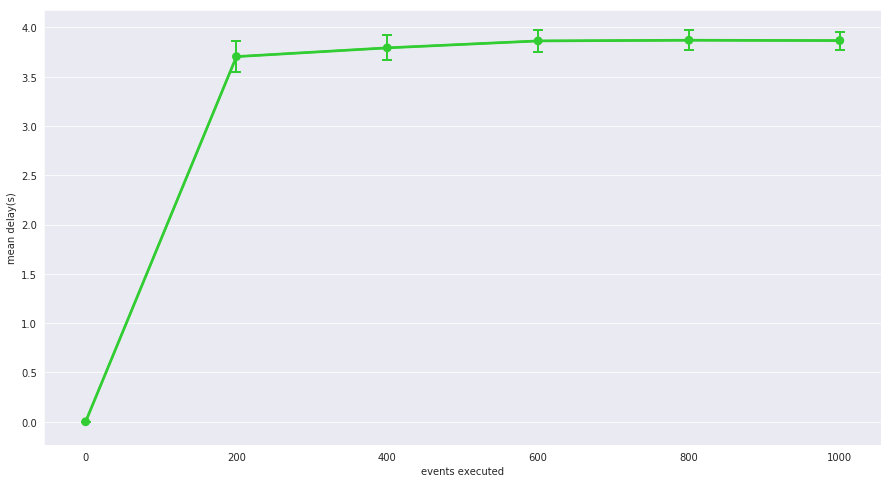

In [8]:
# run a bunch of simulations and collect mean delays and the errors
qs = QueueStatistics()
means = []
errs = []
events = []
queues = [Queue(0.25, 0.5) for _ in range(100)]
for i in range(1001): # we will run 1000 events in each queue
    L = []

    # advance each queue
    for j in range(len(queues)):
        queues[j].goToNextEvent()
    
    # collect metrics
    if i % 200 == 0:
        L = []
        
        for j in range(len(queues)):
            L.append(queues[j].getMeanDelay())
    
        means.append(qs.getMean(L))
        errs.append(qs.getErr(L))
        events.append(i)

# configure some plotting properties
sns.set_style("darkgrid")
sns.set_palette("hls")
plt.rcParams['figure.figsize'] = [15, 8]

# create a pandas dataframe for the collected data
aux = {}
aux["events executed"] = events
aux["mean delay(s)"] = means
df = pd.DataFrame(aux)

# plot the means using seaborn
ax = sns.pointplot(x="events executed", y="mean delay(s)", data=df, color="limegreen", ci = 95)

# plot confidence intervals using matplotlib
ax.errorbar(df.index, means, yerr=errs, fmt="-", color="limegreen", capsize = 5, capthick = 2, linewidth = 2)

plt.show()

Observando o gráfico, concluímos que a partir de 1000 eventos simulados, o efeito do transiente é desprezível. Assim, coletaremos os dados da simulação após ocorrer 1000 eventos. 

Uma vez que descobrimos como remover o transiente da simulação, podemos proceder para a criação do gráfico de retardo médio por utilização. Para isso, iremos variar a taxa de chegada **arrivalRate** de 0.05 até 0.95 e utilizaremos o valor fixo de 1 para a taxa de saída **departureRate**, obtendo assim, diferentes valores de utilização. Para cada um desses valores de utilização, iremos executar 1000 simulações, e cada uma irá executar 1000 eventos.

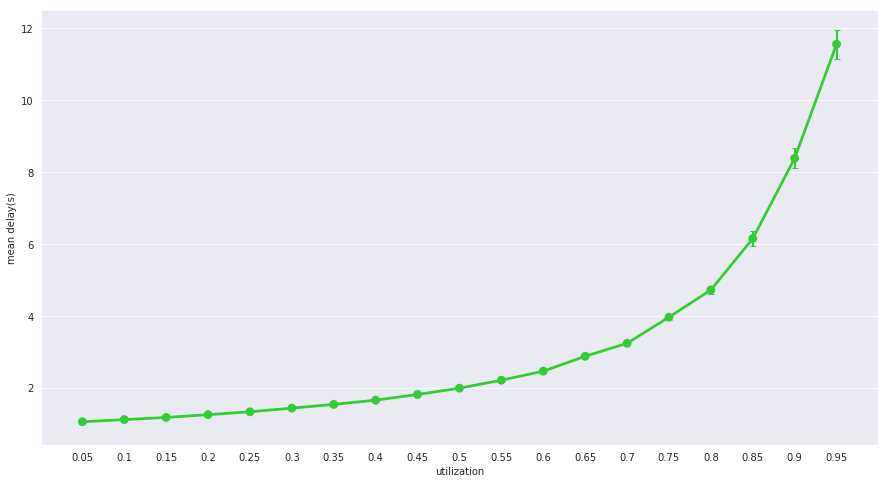

In [9]:
means = []
errs = []
utilization = []
departureRate = 1

# we change the arrival rate to change the utilization
for x in range(5, 100, 5):
    arrivalRate = x / 100.
    L = []
    
    # run a bunch of simulations and collect mean delays and errors
    for j in range(1000):
        q = Queue(arrivalRate, departureRate)
        
        for _ in range(1000):
            q.goToNextEvent()
    
        L.append(q.getMeanDelay())
    
    utilization.append(round(arrivalRate / departureRate, 2))
    means.append(qs.getMean(L))
    errs.append(qs.getErr(L))

# create a pandas dataframe for the collected data
aux = {}
aux["utilization"] = utilization
aux["mean delay(s)"] = means
df = pd.DataFrame(aux)

# plot the means using seaborn
ax = sns.pointplot(x="utilization", y="mean delay(s)", data=df, color="limegreen", ci = 95)

# plot confidence intervals using matplotlib
ax.errorbar(df.index, means, yerr=errs, fmt="-", color="limegreen", capsize = 3, elinewidth = 2)

plt.show()

E portanto, o gráfico obtido é condizente com o esperado.